In [4]:
# Importiamo e leggiamo i file

import pandas as pd
import numpy as np

# GDELT

gdelt_nflx = pd.read_csv("GDELT_NETFLIX_Analysis.csv", sep=';')
gdelt_svb  = pd.read_csv("GDELT_SVB_Analysis.csv", sep=';')

# Controllo
print("GDELT Netflix:", gdelt_nflx.shape, gdelt_nflx.columns.tolist())
print("GDELT SVB:", gdelt_svb.shape, gdelt_svb.columns.tolist())

# Mercato (Event Table)

nflx_mkt = pd.read_csv("Netflix_Event_Table.csv", sep=';')
svb_kre_mkt = pd.read_csv("SVB_KRE_Event_Table.csv", sep=';')

print("Netflix Event Table:", nflx_mkt.shape, nflx_mkt.columns.tolist())
print("SVB-KRE Event Table:", svb_kre_mkt.shape, svb_kre_mkt.columns.tolist())

# Converto le date in datetime
nflx_mkt["Date"] = pd.to_datetime(nflx_mkt["Date"])
svb_kre_mkt["Date"] = pd.to_datetime(svb_kre_mkt["Date"])

# Tweet: DISTILBERT + XLM

# Netflix
nflx_distil = pd.read_csv("tweets_netflix_distilbert_multi.csv")
nflx_xlm    = pd.read_csv("tweet_netflix_xlm.csv")

print("Tweets Netflix DistilBERT:", nflx_distil.shape, nflx_distil.columns.tolist())
print("Tweets Netflix XLM:", nflx_xlm.shape, nflx_xlm.columns.tolist())

# SVB
svb_distil = pd.read_csv("tweets_svb_distilbert_multi.csv")
svb_xlm    = pd.read_csv("tweet_svb_xlm.csv")

print("Tweets SVB DistilBERT:", svb_distil.shape, svb_distil.columns.tolist())
print("Tweets SVB XLM:", svb_xlm.shape, svb_xlm.columns.tolist())


GDELT Netflix: (15, 3) ['day', 'gdelt_volume', 'gdelt_index_pct']
GDELT SVB: (8, 3) ['day', 'gdelt_volume', 'gdelt_index_pct']
Netflix Event Table: (15, 6) ['Date', 'Ticker', 'price_Nflx', 'log_return', 'vol_5d', 'vol_10d']
SVB-KRE Event Table: (8, 6) ['Date', 'Ticker', 'price_Kre', 'log_return', 'vol_5d', 'vol_10d']
Tweets Netflix DistilBERT: (974, 10) ['id', 'text', 'twitterUrl', 'retweetCount', 'replyCount', 'likeCount', 'quoteCount', 'isReply', 'date', 'distilbert_multi_score']
Tweets Netflix XLM: (974, 10) ['id', 'text', 'twitterUrl', 'retweetCount', 'replyCount', 'likeCount', 'quoteCount', 'isReply', 'date', 'xlm_score']
Tweets SVB DistilBERT: (648, 10) ['id', 'text', 'twitterUrl', 'retweetCount', 'replyCount', 'likeCount', 'quoteCount', 'isReply', 'date', 'distilbert_multi_score']
Tweets SVB XLM: (648, 10) ['id', 'text', 'twitterUrl', 'retweetCount', 'replyCount', 'likeCount', 'quoteCount', 'isReply', 'date', 'xlm_score']


In [5]:
# SVB Social Daily

# Merge tra DistilBERT e XLM a livello di singolo tweet
#    Uso 'id' come chiave comune
svb_tweets = pd.merge(
    svb_distil,
    svb_xlm[["id", "xlm_score"]],
    on="id",
    how="inner"
)

print("SVB tweets mergiati:", svb_tweets.shape)

# Assicuro che la colonna 'date' sia datetime (giorno)
#    Se la colonna che contiene la data si chiama diversamente, cambia qui.
svb_tweets["date"] = pd.to_datetime(svb_tweets["date"]).dt.floor("D")

print("Range date SVB tweet-level:",
      svb_tweets["date"].min(),
      "→",
      svb_tweets["date"].max())

# Disagreement a livello di singolo tweet
svb_tweets["mdi_tweet"] = (svb_tweets["xlm_score"] - svb_tweets["distilbert_multi_score"]).abs()

# Aggregazione giornaliera
svb_social_daily = svb_tweets.groupby("date").agg(
    social_volume=("id", "count"),
    sentiment_distilbert_social=("distilbert_multi_score", "mean"),
    sentiment_xlm_social=("xlm_score", "mean"),
    MDI_social=("mdi_tweet", "mean"),
    like_sum=("likeCount", "sum"),
    retweet_sum=("retweetCount", "sum"),
    reply_sum=("replyCount", "sum"),
).reset_index()

# Engagement come somma di like+retweet+reply
svb_social_daily["engagement"] = (
    svb_social_daily["like_sum"] +
    svb_social_daily["retweet_sum"] +
    svb_social_daily["reply_sum"]
)

print("SVB social_daily shape:", svb_social_daily.shape)
print("Range date SVB social_daily:",
      svb_social_daily["date"].min(),
      "→",
      svb_social_daily["date"].max())

svb_social_daily.head()


SVB tweets mergiati: (648, 11)
Range date SVB tweet-level: 2023-03-09 00:00:00 → 2023-03-17 00:00:00
SVB social_daily shape: (9, 9)
Range date SVB social_daily: 2023-03-09 00:00:00 → 2023-03-17 00:00:00


,date,social_volume,sentiment_distilbert_social,sentiment_xlm_social,MDI_social,like_sum,retweet_sum,reply_sum,engagement
0,2023-03-09,1,-1.000000,-0.747536,0.252464,1501,425,91,2017
1,2023-03-10,83,-0.777108,-0.545073,0.408711,102957,24180,4568,131705
2,2023-03-11,100,-0.815000,-0.510814,0.460303,128496,27780,8744,165020
3,2023-03-12,96,-0.536458,-0.273308,0.644684,84260,17342,7075,108677
4,2023-03-13,84,-0.476190,-0.314082,0.559544,131960,31563,20405,183928


In [6]:
# Netflix: Social Daily

# Merge tra DistilBERT e XLM a livello tweet
nflx_tweets = pd.merge(
    nflx_distil,
    nflx_xlm[["id", "xlm_score"]],
    on="id",
    how="inner"
)

print("Netflix tweets mergiati:", nflx_tweets.shape)

# Data in formato datetime (giorno)
nflx_tweets["date"] = pd.to_datetime(nflx_tweets["date"]).dt.floor("D")

print("Range date Netflix tweet-level:",
      nflx_tweets["date"].min(),
      "→",
      nflx_tweets["date"].max())

# Disagreement per tweet
nflx_tweets["mdi_tweet"] = (nflx_tweets["xlm_score"] - nflx_tweets["distilbert_multi_score"]).abs()

# Aggregazione giornaliera
nflx_social_daily = nflx_tweets.groupby("date").agg(
    social_volume=("id", "count"),
    sentiment_distilbert_social=("distilbert_multi_score", "mean"),
    sentiment_xlm_social=("xlm_score", "mean"),
    MDI_social=("mdi_tweet", "mean"),
    like_sum=("likeCount", "sum"),
    retweet_sum=("retweetCount", "sum"),
    reply_sum=("replyCount", "sum"),
).reset_index()

# Engagement
nflx_social_daily["engagement"] = (
    nflx_social_daily["like_sum"] +
    nflx_social_daily["retweet_sum"] +
    nflx_social_daily["reply_sum"]
)

print("Netflix social_daily shape:", nflx_social_daily.shape)
print("Range date Netflix social_daily:",
      nflx_social_daily["date"].min(),
      "→",
      nflx_social_daily["date"].max())

nflx_social_daily.head()


Netflix tweets mergiati: (974, 11)
Range date Netflix tweet-level: 2022-04-19 00:00:00 → 2026-01-15 00:00:00
Netflix social_daily shape: (18, 9)
Range date Netflix social_daily: 2022-04-19 00:00:00 → 2026-01-15 00:00:00


,date,social_volume,sentiment_distilbert_social,sentiment_xlm_social,MDI_social,like_sum,retweet_sum,reply_sum,engagement
0,2022-04-19,110,-0.836364,-0.465811,0.512704,139264,15627,9452,164343
1,2022-04-20,28,-0.875000,-0.402396,0.579747,38865,5218,2495,46578
2,2022-04-21,85,-0.741176,-0.491254,0.469117,133972,13619,3701,151292
3,2022-04-22,18,-0.111111,-0.093487,0.487982,34014,6914,1120,42048
4,2022-04-23,98,-0.219388,-0.234118,0.448804,131098,21830,3062,155990


In [7]:
# FINAL MERGE SVB: SOCIAL + KRE

# Rinomino 'Date' in 'date' per avere la stessa chiave
svb_kre_mkt = svb_kre_mkt.rename(columns={"Date": "date"})
svb_kre_mkt["date"] = pd.to_datetime(svb_kre_mkt["date"]).dt.floor("D")

print("Range date SVB mercato:",
      svb_kre_mkt["date"].min(),
      "→",
      svb_kre_mkt["date"].max())

# Final merge: solo i giorni in cui hai sia social che mercato
svb_social_market_merged = pd.merge(
    svb_kre_mkt,
    svb_social_daily,
    on="date",
    how="inner"
)

print("SVB social+market merged shape:", svb_social_market_merged.shape)
print("Range date SVB merged:",
      svb_social_market_merged["date"].min(),
      "→",
      svb_social_market_merged["date"].max())

svb_social_market_merged.head()

# Salvo il dataset finale
svb_social_market_merged.to_csv("SVB_social_market_merged.csv", index=False)


Range date SVB mercato: 2023-03-10 00:00:00 → 2023-03-17 00:00:00
SVB social+market merged shape: (8, 14)
Range date SVB merged: 2023-03-10 00:00:00 → 2023-03-17 00:00:00


In [8]:
# FINAL MERGE NETFLIX: SOCIAL + MERCATO

# Rinomino 'Date' in 'date'
nflx_mkt = nflx_mkt.rename(columns={"Date": "date"})
nflx_mkt["date"] = pd.to_datetime(nflx_mkt["date"]).dt.floor("D")

print("Range date Netflix mercato:",
      nflx_mkt["date"].min(),
      "→",
      nflx_mkt["date"].max())

# Merge social + mercato
nflx_social_market_merged = pd.merge(
    nflx_mkt,
    nflx_social_daily,
    on="date",
    how="inner"
)

print("Netflix social+market merged shape:", nflx_social_market_merged.shape)
print("Range date Netflix merged:",
      nflx_social_market_merged["date"].min(),
      "→",
      nflx_social_market_merged["date"].max())

nflx_social_market_merged.head()

# Salvo
nflx_social_market_merged.to_csv("Netflix_social_market_merged.csv", index=False)


Range date Netflix mercato: 2022-04-19 00:00:00 → 2022-05-03 00:00:00
Netflix social+market merged shape: (15, 14)
Range date Netflix merged: 2022-04-19 00:00:00 → 2022-05-03 00:00:00


In [9]:
# GDELT SVB

gdelt_svb = pd.read_csv("GDELT_SVB_Analysis.csv", sep=';')

print("GDELT SVB:", gdelt_svb.shape)
print(gdelt_svb.columns)

# Rinomino la colonna giorno → date (adatta se il nome è diverso)
gdelt_svb = gdelt_svb.rename(columns={"day": "date"})

# Converto a datetime giornaliero
gdelt_svb["date"] = pd.to_datetime(gdelt_svb["date"]).dt.floor("D")

print(
    "Range date GDELT SVB:",
    gdelt_svb["date"].min(),
    "→",
    gdelt_svb["date"].max()
)

gdelt_svb.head()


GDELT SVB: (8, 3)
Index(['day', 'gdelt_volume', 'gdelt_index_pct'], dtype='object')
Range date GDELT SVB: 2023-03-10 00:00:00 → 2023-03-17 00:00:00


,date,gdelt_volume,gdelt_index_pct
0,2023-03-10,1208,19.386936
1,2023-03-11,1935,31.054405
2,2023-03-12,2614,41.951533
3,2023-03-13,6231,100.000000
4,2023-03-14,5228,83.903065


In [10]:
# FINAL MERGE SVB: SOCIAL + MERCATO + GDELT

svb_full_merged = pd.merge(
    svb_social_market_merged,
    gdelt_svb,
    on="date",
    how="left"   # GDELT come layer esogeno
)

print("SVB FULL merged shape:", svb_full_merged.shape)
print(
    "Range date SVB FULL:",
    svb_full_merged["date"].min(),
    "→",
    svb_full_merged["date"].max()
)

svb_full_merged.head()


SVB FULL merged shape: (8, 16)
Range date SVB FULL: 2023-03-10 00:00:00 → 2023-03-17 00:00:00


,date,Ticker,price_Kre,log_return,vol_5d,vol_10d,social_volume,sentiment_distilbert_social,sentiment_xlm_social,MDI_social,like_sum,retweet_sum,reply_sum,engagement,gdelt_volume,gdelt_index_pct
0,2023-03-10,SVB,46.320663,-0.044941,0.032439,0.028534,83,-0.777108,-0.545073,0.408711,102957,24180,4568,131705,1208,19.386936
1,2023-03-11,SVB,NaN,NaN,NaN,NaN,100,-0.815000,-0.510814,0.460303,128496,27780,8744,165020,1935,31.054405
2,2023-03-12,SVB,NaN,NaN,NaN,NaN,96,-0.536458,-0.273308,0.644684,84260,17342,7075,108677,2614,41.951533
3,2023-03-13,SVB,40.618542,-0.131364,0.049173,0.044378,84,-0.476190,-0.314082,0.559544,131960,31563,20405,183928,6231,100.000000
4,2023-03-14,SVB,41.468380,0.020707,0.060921,0.046622,62,-0.693548,-0.549116,0.536971,47077,10709,7384,65170,5228,83.903065


In [11]:
# FINAL MERGE NETFLIX: SOCIAL + MERCATO + GDELT

gdelt_nflx = pd.read_csv("GDELT_NETFLIX_Analysis.csv", sep=';')

gdelt_nflx = gdelt_nflx.rename(columns={"day": "date"})
gdelt_nflx["date"] = pd.to_datetime(gdelt_nflx["date"]).dt.floor("D")

nflx_full_merged = pd.merge(
    nflx_social_market_merged,
    gdelt_nflx,
    on="date",
    how="left"
)

print("Netflix FULL merged shape:", nflx_full_merged.shape)
print(
    "Range date Netflix FULL:",
    nflx_full_merged["date"].min(),
    "→",
    nflx_full_merged["date"].max()
)

nflx_full_merged.head()


Netflix FULL merged shape: (15, 16)
Range date Netflix FULL: 2022-04-19 00:00:00 → 2022-05-03 00:00:00


,date,Ticker,price_Nflx,log_return,vol_5d,vol_10d,social_volume,sentiment_distilbert_social,sentiment_xlm_social,MDI_social,like_sum,retweet_sum,reply_sum,engagement,gdelt_volume,gdelt_index_pct
0,2022-04-19,Netflix,34.861000,0.031322,0.023749,0.020722,110,-0.836364,-0.465811,0.512704,139264,15627,9452,164343,1400,38.620690
1,2022-04-20,Netflix,22.618999,-0.432578,0.196245,0.135201,28,-0.875000,-0.402396,0.579747,38865,5218,2495,46578,3625,100.000000
2,2022-04-21,Netflix,21.822001,-0.035872,0.190616,0.135135,85,-0.741176,-0.491254,0.469117,133972,13619,3701,151292,1855,51.172414
3,2022-04-22,Netflix,21.552000,-0.012450,0.192006,0.135274,18,-0.111111,-0.093487,0.487982,34014,6914,1120,42048,1340,36.965517
4,2022-04-23,Netflix,NaN,NaN,NaN,NaN,98,-0.219388,-0.234118,0.448804,131098,21830,3062,155990,848,23.393103


In [12]:
# Arrotondiamo per rendere i codici leggibili

cols_to_round = [
    "sentiment_distilbert_social",
    "sentiment_xlm_social",
    "MDI_social",
    "log_return",
    "vol_5d",
    "vol_10d"
]

# Arrotondo SVB
svb_full_merged[cols_to_round] = svb_full_merged[cols_to_round].round(2)

# Arrotondo Netflix
nflx_full_merged[cols_to_round] = nflx_full_merged[cols_to_round].round(2)

svb_full_merged.head(), nflx_full_merged.head()


(        date Ticker  price_Kre  log_return  vol_5d  vol_10d  social_volume  \
 0 2023-03-10    SVB  46.320663       -0.04    0.03     0.03             83   
 1 2023-03-11    SVB        NaN         NaN     NaN      NaN            100   
 2 2023-03-12    SVB        NaN         NaN     NaN      NaN             96   
 3 2023-03-13    SVB  40.618542       -0.13    0.05     0.04             84   
 4 2023-03-14    SVB  41.468380        0.02    0.06     0.05             62   
 
    sentiment_distilbert_social  sentiment_xlm_social  MDI_social  like_sum  \
 0                        -0.78                 -0.55        0.41    102957   
 1                        -0.82                 -0.51        0.46    128496   
 2                        -0.54                 -0.27        0.64     84260   
 3                        -0.48                 -0.31        0.56    131960   
 4                        -0.69                 -0.55        0.54     47077   
 
    retweet_sum  reply_sum  engagement  gdelt_vo

In [ ]:
# Salvataggio csv. finali

svb_full_merged.to_csv(
    "SVB_FINAL_social.csv",
    index=False
)

nflx_full_merged.to_csv(
    "Netflix_FINAL_social.csv",
    index=False
)

print("CSV finali salvati correttamente.")


CSV finali salvati correttamente.


**Grafici**

   MDI_social  vol_5d
0        0.41    0.03
3        0.56    0.05
4        0.54    0.06
5        0.51    0.06
6        0.47    0.07


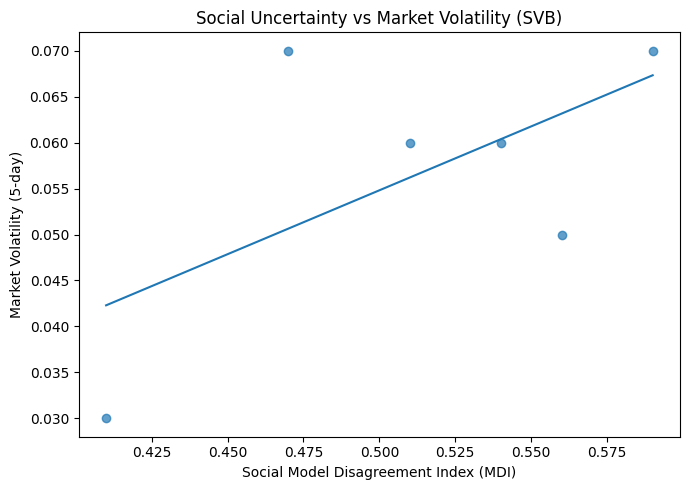

In [ ]:
# Grafico 1 – MDI_social vs Volatilità (SVB)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Carico il dataset finale SVB
svb = pd.read_csv("SVB_FINAL_social.csv")

# Controllo rapido
print(svb[["MDI_social", "vol_5d"]].dropna().head())

# Rimuovo eventuali NaN
df = svb[["MDI_social", "vol_5d"]].dropna()

# Scatter plot

plt.figure(figsize=(7, 5))
plt.scatter(
    df["MDI_social"],
    df["vol_5d"],
    alpha=0.7
)

# Regressione lineare (OLS semplice)

x = df["MDI_social"].values
y = df["vol_5d"].values

coef = np.polyfit(x, y, 1)
poly1d_fn = np.poly1d(coef)

# Linea di regressione
x_sorted = np.sort(x)
plt.plot(x_sorted, poly1d_fn(x_sorted))

# Etichette e titolo

plt.xlabel("Social Model Disagreement Index (MDI)")
plt.ylabel("Market Volatility (5-day)")
plt.title("Social Uncertainty vs Market Volatility (SVB)")

plt.tight_layout()
plt.savefig("figures/fig1_MDI_vs_vol_SVB.png", dpi=300)
plt.show()


   MDI_social  vol_5d
0        0.51    0.02
1        0.58    0.20
2        0.47    0.19
3        0.49    0.19
6        0.73    0.19


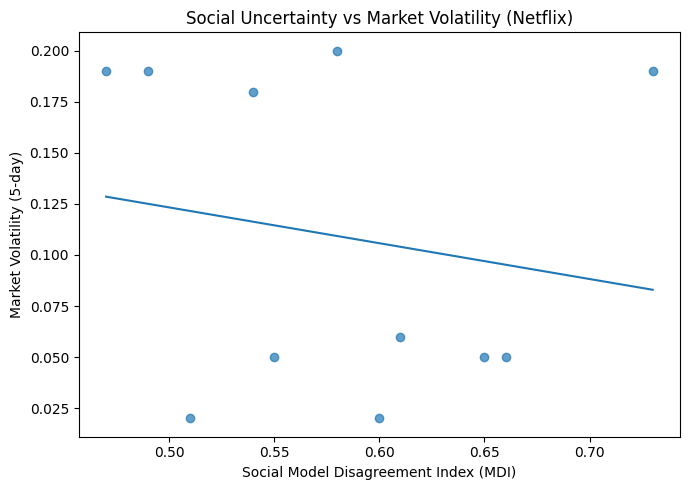

In [ ]:
# Grafico 1 – MDI_social vs Volatilità (Netflix)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Carico il dataset finale Netflix
nflx = pd.read_csv("Netflix_FINAL_social.csv")

# Controllo rapido
print(nflx[["MDI_social", "vol_5d"]].dropna().head())

# Rimuovo eventuali NaN
df = nflx[["MDI_social", "vol_5d"]].dropna()

# Scatter plot
plt.figure(figsize=(7, 5))
plt.scatter(
    df["MDI_social"],
    df["vol_5d"],
    alpha=0.7
)

# Regressione lineare

x = df["MDI_social"].values
y = df["vol_5d"].values

coef = np.polyfit(x, y, 1)
poly1d_fn = np.poly1d(coef)

x_sorted = np.sort(x)
plt.plot(x_sorted, poly1d_fn(x_sorted))

# Etichette e titolo

plt.xlabel("Social Model Disagreement Index (MDI)")
plt.ylabel("Market Volatility (5-day)")
plt.title("Social Uncertainty vs Market Volatility (Netflix)")

plt.tight_layout()
plt.savefig("figures/fig1_MDI_vs_vol_Netflix.png", dpi=300)
plt.show()


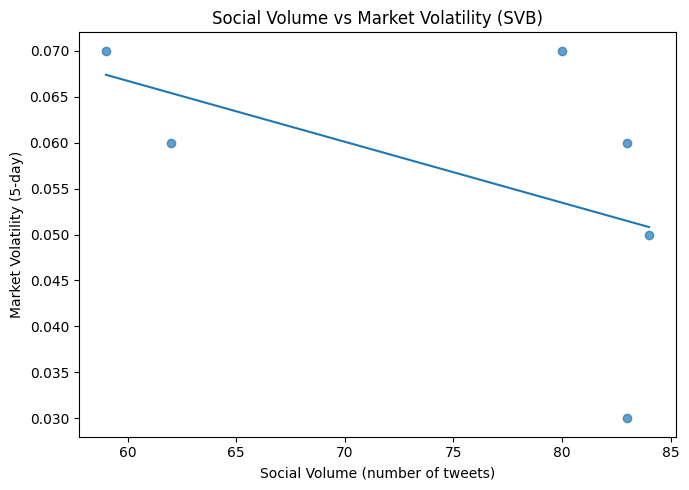

In [ ]:
# Grafico 2 – Social Volume vs Volatilità (SVB)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Dataset finale SVB
svb = pd.read_csv("SVB_FINAL_social.csv")

# Selezione variabili e rimozione NaN
df = svb[["social_volume", "vol_5d"]].dropna()

# Scatter plot
plt.figure(figsize=(7, 5))
plt.scatter(
    df["social_volume"],
    df["vol_5d"],
    alpha=0.7
)

# Regressione lineare
x = df["social_volume"].values
y = df["vol_5d"].values

coef = np.polyfit(x, y, 1)
poly1d_fn = np.poly1d(coef)

x_sorted = np.sort(x)
plt.plot(x_sorted, poly1d_fn(x_sorted))

# Etichette
plt.xlabel("Social Volume (number of tweets)")
plt.ylabel("Market Volatility (5-day)")
plt.title("Social Volume vs Market Volatility (SVB)")

plt.tight_layout()
plt.savefig("figures/fig2_socialvolume_vs_marketvol__SVB.png", dpi=300)
plt.show()


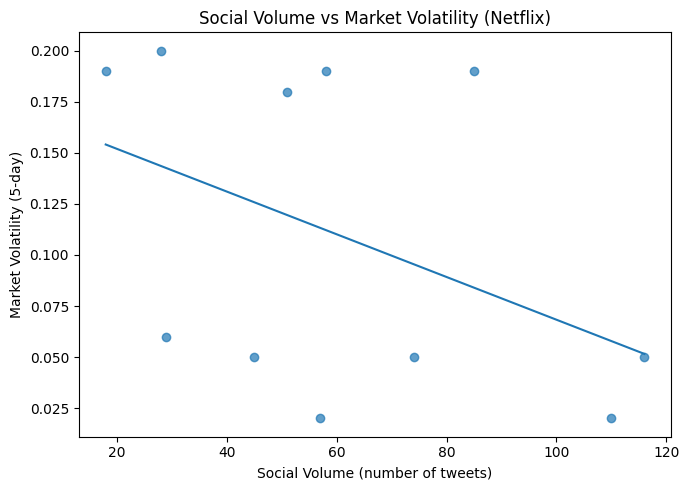

In [ ]:
# Grafico 2 – Social Volume vs Volatilità (Netflix)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Dataset finale Netflix
nflx = pd.read_csv("Netflix_FINAL_social.csv")

# Selezione variabili
df = nflx[["social_volume", "vol_5d"]].dropna()

# Scatter plot
plt.figure(figsize=(7, 5))
plt.scatter(
    df["social_volume"],
    df["vol_5d"],
    alpha=0.7
)

# Regressione lineare
x = df["social_volume"].values
y = df["vol_5d"].values

coef = np.polyfit(x, y, 1)
poly1d_fn = np.poly1d(coef)

x_sorted = np.sort(x)
plt.plot(x_sorted, poly1d_fn(x_sorted))

# Etichette
plt.xlabel("Social Volume (number of tweets)")
plt.ylabel("Market Volatility (5-day)")
plt.title("Social Volume vs Market Volatility (Netflix)")

plt.tight_layout()
plt.savefig("figures/fig2_socialvolume_vs_marketvol__NFLX.png", dpi=300)
plt.show()


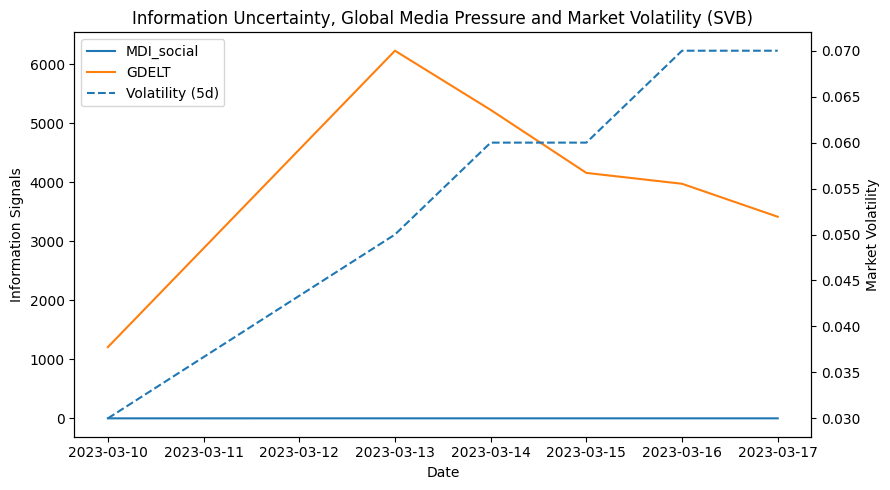

In [ ]:
# Grafico 3 – Time series MDI, GDELT e Volatilità (SVB)

import pandas as pd
import matplotlib.pyplot as plt

# Dataset finale SVB
svb = pd.read_csv("SVB_FINAL_social.csv")

# Assicuro formato data
svb["date"] = pd.to_datetime(svb["date"])

# Seleziono solo le colonne utili e rimuovo NaN
df = svb[["date", "MDI_social", "vol_5d"]].copy()

# Se la colonna GDELT ha un nome specifico, adattalo qui
# esempio: "gdelt_volume" / "global_event_count" ecc.
gdelt_col = [c for c in svb.columns if "gdelt" in c.lower()][0]
df["GDELT"] = svb[gdelt_col]

df = df.dropna()

# ============================
# Plot
# ============================

fig, ax1 = plt.subplots(figsize=(9, 5))

# Asse sinistro: MDI + GDELT
ax1.plot(df["date"], df["MDI_social"], label="MDI_social")
ax1.plot(df["date"], df["GDELT"], label="GDELT")
ax1.set_xlabel("Date")
ax1.set_ylabel("Information Signals")

# Asse destro: Volatilità
ax2 = ax1.twinx()
ax2.plot(df["date"], df["vol_5d"], linestyle="--", label="Volatility (5d)")
ax2.set_ylabel("Market Volatility")

# Titolo
plt.title("Information Uncertainty, Global Media Pressure and Market Volatility (SVB)")

# Legenda combinata
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left")

plt.tight_layout()
plt.savefig("figures/fig3_timeseries_SVB.png", dpi=300)
plt.show()


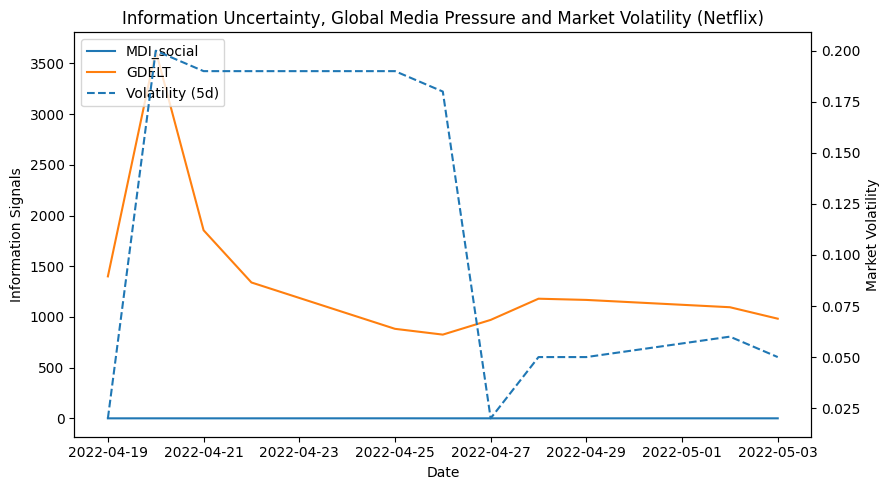

In [ ]:
# Grafico 3 – Time series MDI, GDELT e Volatilità (Netflix)

import pandas as pd
import matplotlib.pyplot as plt

# Dataset finale Netflix
nflx = pd.read_csv("Netflix_FINAL_social.csv")
nflx["date"] = pd.to_datetime(nflx["date"])

df = nflx[["date", "MDI_social", "vol_5d"]].copy()

gdelt_col = [c for c in nflx.columns if "gdelt" in c.lower()][0]
df["GDELT"] = nflx[gdelt_col]

df = df.dropna()

fig, ax1 = plt.subplots(figsize=(9, 5))

# Asse sinistro
ax1.plot(df["date"], df["MDI_social"], label="MDI_social")
ax1.plot(df["date"], df["GDELT"], label="GDELT")
ax1.set_xlabel("Date")
ax1.set_ylabel("Information Signals")

# Asse destro
ax2 = ax1.twinx()
ax2.plot(df["date"], df["vol_5d"], linestyle="--", label="Volatility (5d)")
ax2.set_ylabel("Market Volatility")

plt.title("Information Uncertainty, Global Media Pressure and Market Volatility (Netflix)")

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left")

plt.tight_layout()
plt.savefig("figures/fig3_timeseries_Netflix.png", dpi=300)
plt.show()


In [ ]:
import os

os.makedirs("figures", exist_ok=True)

**Modifichiamo Grafico 3**

In [ ]:
# Grafico 3
# Time series con MDI_social e GDELT (gdelt_volume) standardizzati (z-score) + Volatilità

import os
import pandas as pd
import matplotlib.pyplot as plt

# Ricarico i dataset finali
svb  = pd.read_csv("SVB_FINAL_social.csv")
nflx = pd.read_csv("Netflix_FINAL_social.csv")

svb["date"]  = pd.to_datetime(svb["date"])
nflx["date"] = pd.to_datetime(nflx["date"])

# MODIFICA IMPORTANTE:
# usiamo esplicitamente 'gdelt_volume' come misura GDELT
# (pressione informativa globale, volume di copertura)
#
GDELT_COL = "gdelt_volume"
#

def timeseries_zscore(df, title, filename):
    """
    MODIFICA: standardizziamo MDI_social e GDELT (gdelt_volume) tramite z-score
    per renderli confrontabili sullo stesso asse, dato che hanno ordini di
    grandezza diversi. La volatilità resta non standardizzata su un secondo asse.
    """

    # Selezione colonne necessarie
    sub = df[["date", "MDI_social", GDELT_COL, "vol_5d"]].dropna().copy()

    # MODIFICA: standardizzazione (z-score)
    sub["MDI_z"]   = (sub["MDI_social"] - sub["MDI_social"].mean()) / sub["MDI_social"].std()
    sub["GDELT_z"] = (sub[GDELT_COL]    - sub[GDELT_COL].mean())    / sub[GDELT_COL].std()
    # ---------------------------------------------

    fig, ax1 = plt.subplots(figsize=(9, 5))

    # Asse sinistro: segnali informativi standardizzati
    ax1.plot(sub["date"], sub["MDI_z"],   label="MDI_social (z-score)")
    ax1.plot(sub["date"], sub["GDELT_z"], label="GDELT volume (z-score)")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Standardized information signals (z-score)")

    # Asse destro: volatilità non standardizzata
    ax2 = ax1.twinx()
    ax2.plot(sub["date"], sub["vol_5d"], linestyle="--", label="Volatility (5d)")
    ax2.set_ylabel("Market Volatility (5-day)")

    # Legenda combinata
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left")

    plt.title(title)
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.close()


# SVB
timeseries_zscore(
    svb,
    "Standardized Social Uncertainty, Global Media Pressure and Market Volatility (SVB)",
    "figures/fig3_timeseries_z_SVB.png"
)

# NETFLIX
timeseries_zscore(
    nflx,
    "Standardized Social Uncertainty, Global Media Pressure and Market Volatility (Netflix)",
    "figures/fig3_timeseries_z_Netflix.png"
)

print("Grafico 3 aggiornato con z-score e 'gdelt_volume' (SVB & Netflix)")


Grafico 3 aggiornato con z-score e 'gdelt_volume' (SVB & Netflix)


In [ ]:
print(svb.columns)


Index(['date', 'Ticker', 'price_Kre', 'log_return', 'vol_5d', 'vol_10d',
       'social_volume', 'sentiment_distilbert_social', 'sentiment_xlm_social',
       'MDI_social', 'like_sum', 'retweet_sum', 'reply_sum', 'engagement',
       'gdelt_volume', 'gdelt_index_pct'],
      dtype='object')


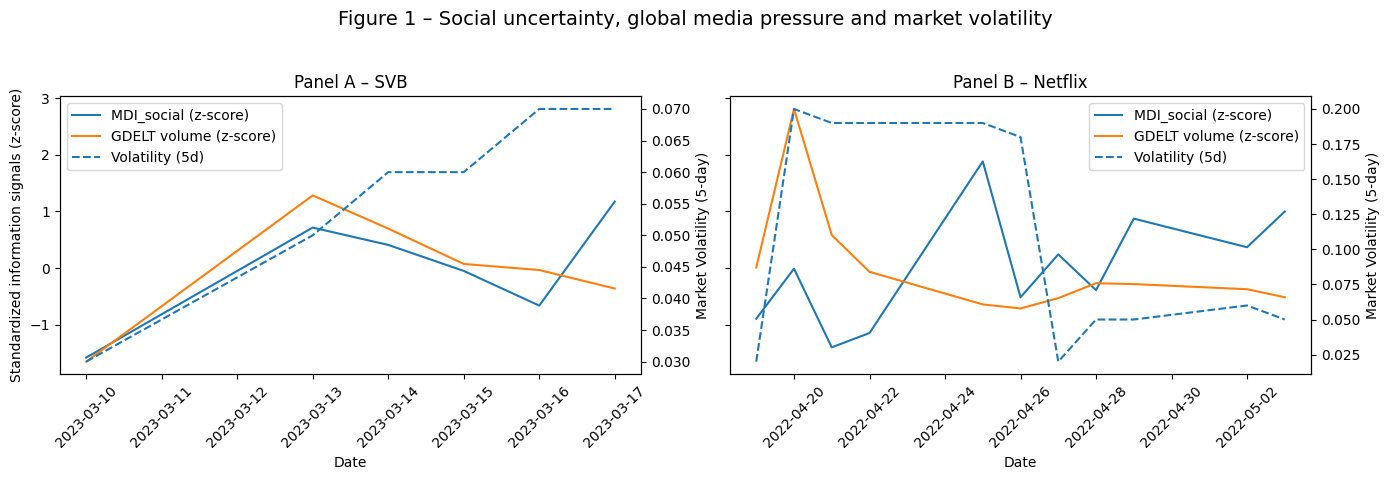

Figura 1 salvata in 'figures/Figure1_social_MDI_GDELT_volatility.png'


In [14]:
# FIGURA 1 – Social information vs market volatility
# Panel A: SVB   |   Panel B: Netflix
# Contenuto: MDI_social (z-score), GDELT volume (z-score), Volatilità (5d)
#
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Ensure the 'figures' directory exists
os.makedirs("figures", exist_ok=True)

# 1. Caricamento dataset finali

svb  = pd.read_csv("SVB_FINAL_social.csv")
nflx = pd.read_csv("Netflix_FINAL_social.csv")

svb["date"]  = pd.to_datetime(svb["date"])
nflx["date"] = pd.to_datetime(nflx["date"])

GDELT_COL = "gdelt_volume"  # <-- colonna GDELT (pressione informativa globale)

def prepare_ts(df):
    """
    MODIFICA: qui standardizziamo MDI_social e gdelt_volume (z-score)
    per renderli confrontabili sullo stesso asse.
    La volatilità (vol_5d) resta nella sua scala e sarà plottata su un asse separato.
    """
    sub = df[["date", "MDI_social", GDELT_COL, "vol_5d"]].dropna().copy()

    sub["MDI_z"]   = (sub["MDI_social"] - sub["MDI_social"].mean()) / sub["MDI_social"].std()
    sub["GDELT_z"] = (sub[GDELT_COL]    - sub[GDELT_COL].mean())    / sub[GDELT_COL].std()

    return sub

svb_ts  = prepare_ts(svb)
nflx_ts = prepare_ts(nflx)

# 2. Creazione figura con due pannelli (SVB / Netflix)

fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# PANEL A – SVB
ax2 = ax1.twinx()  # asse destro per la volatilità

# segnali informativi (asse sinistro)
ax1.plot(svb_ts["date"], svb_ts["MDI_z"],   label="MDI_social (z-score)")
ax1.plot(svb_ts["date"], svb_ts["GDELT_z"], label="GDELT volume (z-score)")

ax1.set_xlabel("Date")
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax1.tick_params(axis="x", rotation=45)
ax1.set_ylabel("Standardized information signals (z-score)")
ax1.set_title("Panel A – SVB")

# volatilità (asse destro)
ax2.plot(svb_ts["date"], svb_ts["vol_5d"], linestyle="--", label="Volatility (5d)")
ax2.set_ylabel("Market Volatility (5-day)")

# legenda combinata panel A
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left")

# PANEL B – Netflix
ax4 = ax3.twinx()  # asse destro per la volatilità

ax3.plot(nflx_ts["date"], nflx_ts["MDI_z"],   label="MDI_social (z-score)")
ax3.plot(nflx_ts["date"], nflx_ts["GDELT_z"], label="GDELT volume (z-score)")

ax3.set_xlabel("Date")
ax3.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax3.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax3.tick_params(axis="x", rotation=45)
ax3.set_title("Panel B – Netflix")

ax4.plot(nflx_ts["date"], nflx_ts["vol_5d"], linestyle="--", label="Volatility (5d)")
ax4.set_ylabel("Market Volatility (5-day)")

# legenda combinata panel B
lines_3, labels_3 = ax3.get_legend_handles_labels()
lines_4, labels_4 = ax4.get_legend_handles_labels()
ax3.legend(lines_3 + lines_4, labels_3 + labels_4, loc="upper right")


# 3. Titolo generale, layout e salvataggio

fig.suptitle("Figure 1 – Social uncertainty, global media pressure and market volatility", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Salvataggio in alta risoluzione
plt.savefig("figures/Figure1_social_MDI_GDELT_volatility.png", dpi=300)
plt.show()

print("Figura 1 salvata in 'figures/Figure1_social_MDI_GDELT_volatility.png'")
